# Basic example using the MOSM, Conv, CSM and SM-LMC kernels
Here we show the basic usage of the toolkit using a contrived example dataset of three sinusoidal signals. The three sinusses are each put in a channel and have the same frequency but differ in phase. The observations are randomly picked in the range of [0,4], where the first channel will have the second half of the observations removed. Each of the kernels is being evaluated on the same dataset so that we can easily compare the results. Finally, a comparison is made between the different kernels and the errors they obtain.

In [25]:
import mogptk
import numpy as np

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

## Generate dataset

In [26]:
data = mogptk.Data()

#Sine(6X) + Noise
x = np.sort(np.random.uniform(0, 4, 20))
y = np.sin(6*x) + np.random.standard_t(3, x.shape)*0.03
data.add(x, y)

#Sine(6X+2) + Noise
x = np.sort(np.random.uniform(0, 4, 10))
y = np.sin(6*x + 2) + np.random.standard_t(3, x.shape)*0.03
data.add(x, y)

#Sine(6X+2) - Sine(4X) + Noise
x = np.sort(np.random.uniform(0, 4, 10))
y = np.sin(6*x + 2) - np.sin(4*x) + np.random.standard_t(3, x.shape)*0.03
data.add(x, y)

data.remove_range(0, start=2.0, end=None)

data.set_latent_function(0, lambda x: np.sin(6*x))
data.set_latent_function(1, lambda x: np.sin(6*x+2))
data.set_latent_function(2, lambda x: np.sin(6*x+2)-np.sin(4*x))

## MOSM

In [27]:
kernel = mogptk.MOSM(data, components=3)
model_mosm = mogptk.Model(data, kernel)
model_mosm.optimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -15.226977
  Number of iterations: 1000
  Number of functions evaluations: 1152


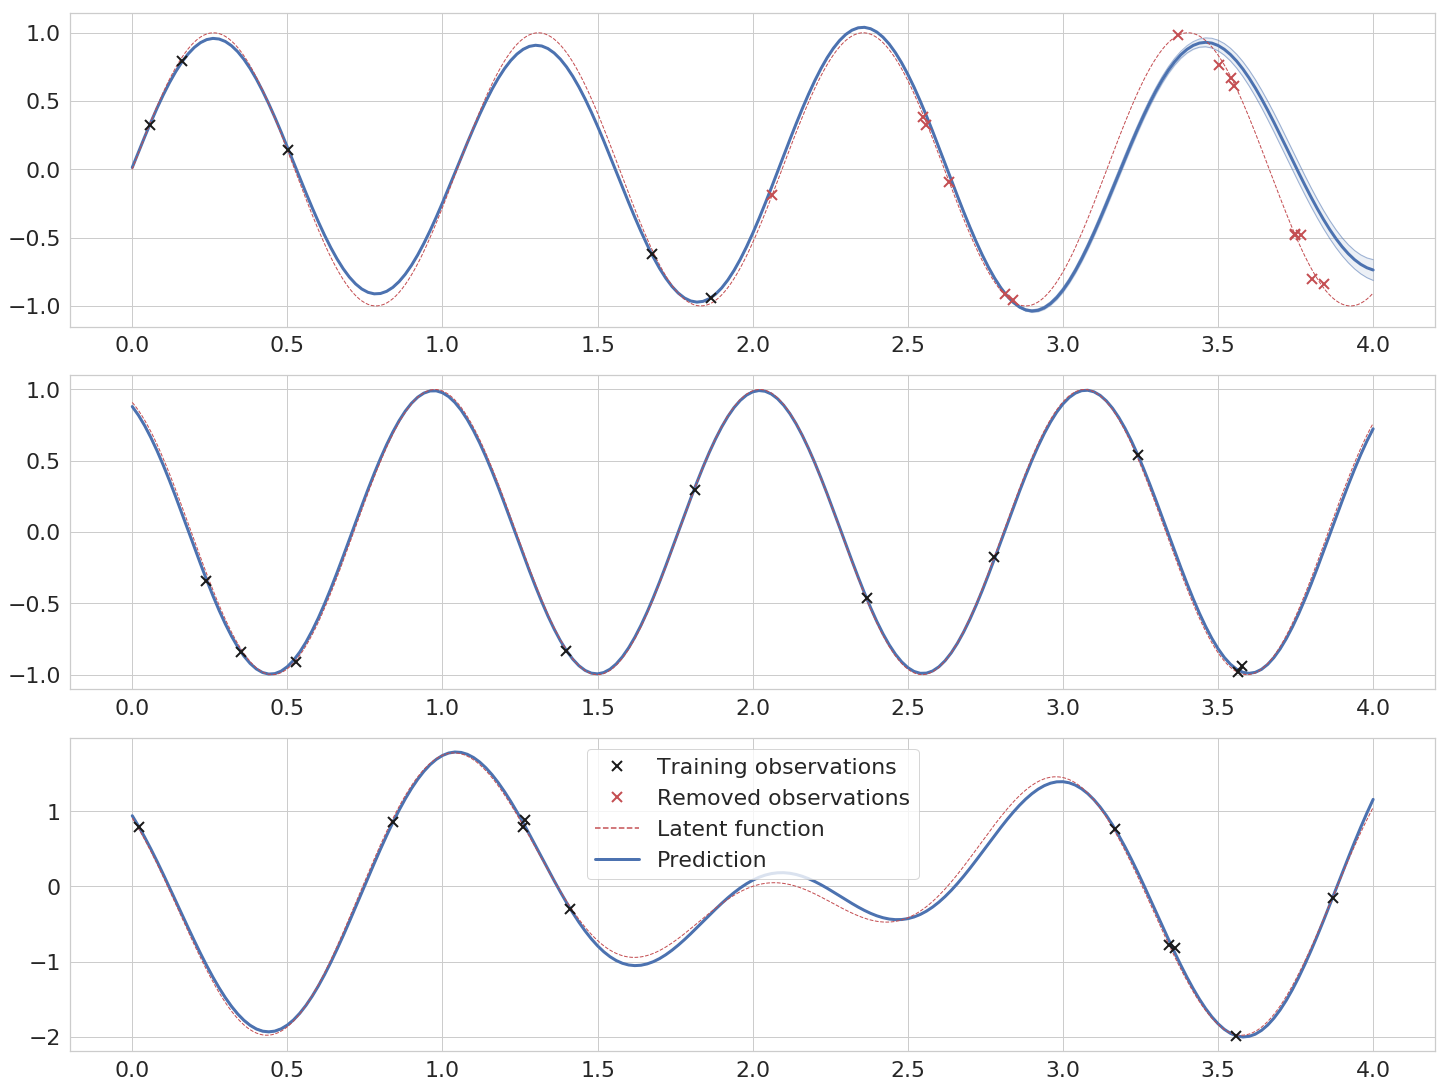

In [28]:
model_mosm.set_prediction_range(channel=0, start=0, end=4, step=0.02)
model_mosm.set_prediction_range(channel=1, start=0, end=4, step=0.02)
model_mosm.set_prediction_range(channel=2, start=0, end=4, step=0.02)
model_mosm.predict()

mogptk.plot(model_mosm)

## CSM

In [29]:
kernel = mogptk.CSM(data, components=3)
model_csm = mogptk.Model(data, kernel)
model_csm.optimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 25.723316
  Number of iterations: 42
  Number of functions evaluations: 47


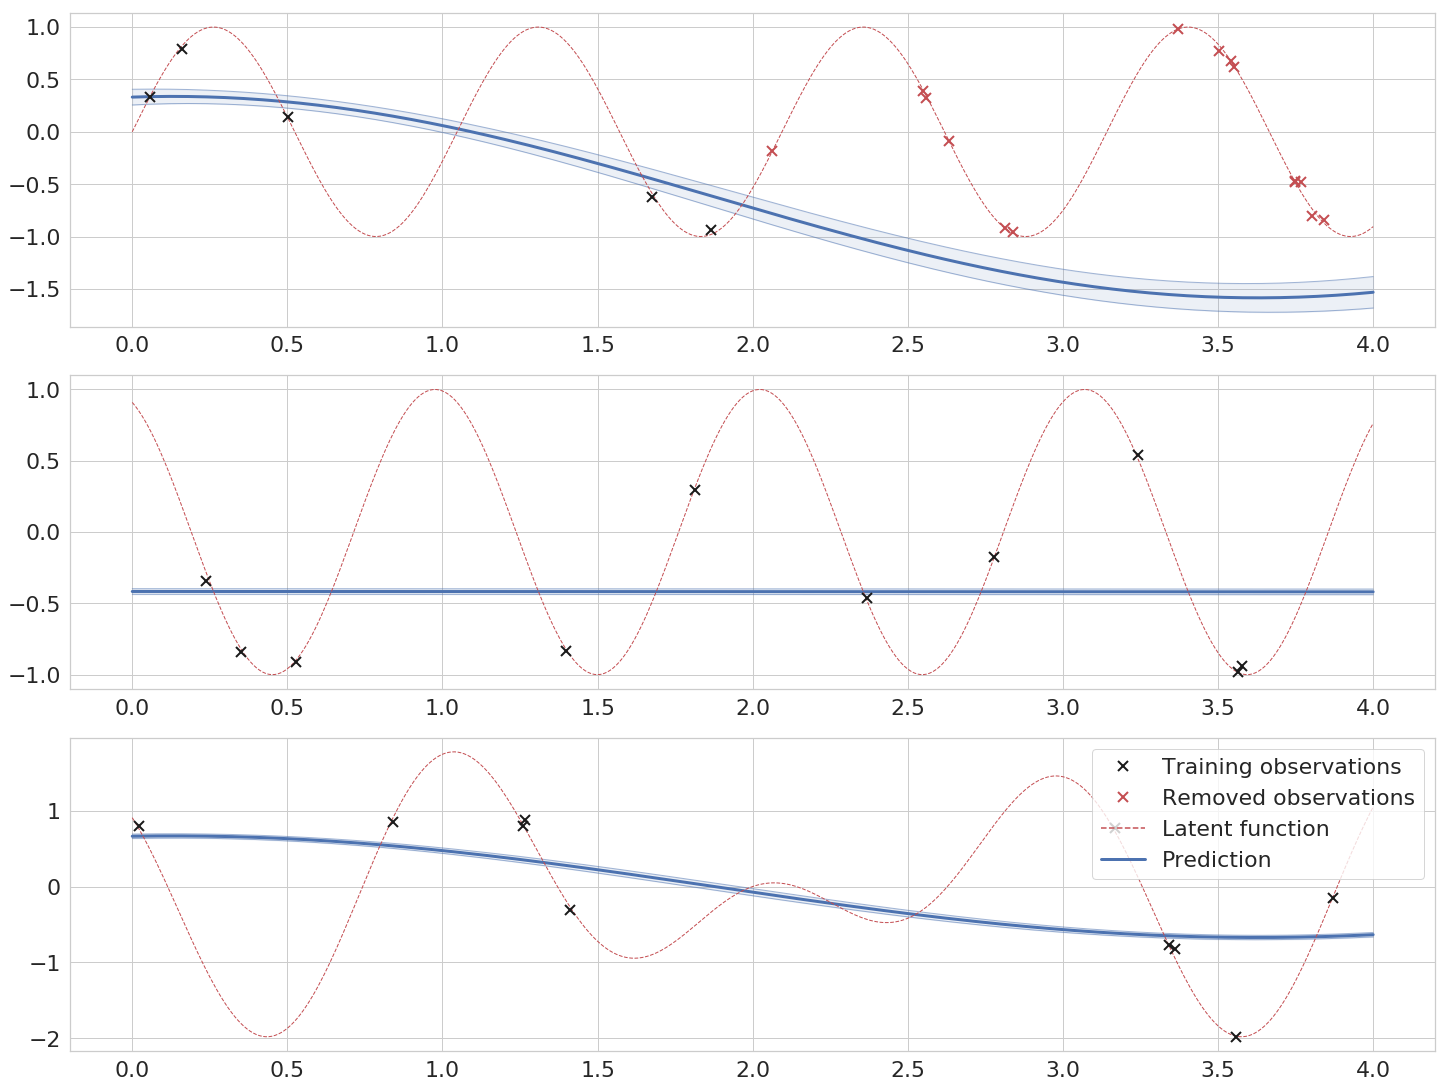

In [30]:
model_csm.set_prediction_range(channel=0, start=0, end=4, step=0.02)
model_csm.set_prediction_range(channel=1, start=0, end=4, step=0.02)
model_csm.set_prediction_range(channel=2, start=0, end=4, step=0.02)
model_csm.predict()

mogptk.plot(model_csm)

## CG

In [31]:
kernel = mogptk.CG(data, components=3)
model_cg = mogptk.Model(data, kernel)
model_cg.optimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 26.685897
  Number of iterations: 53
  Number of functions evaluations: 58


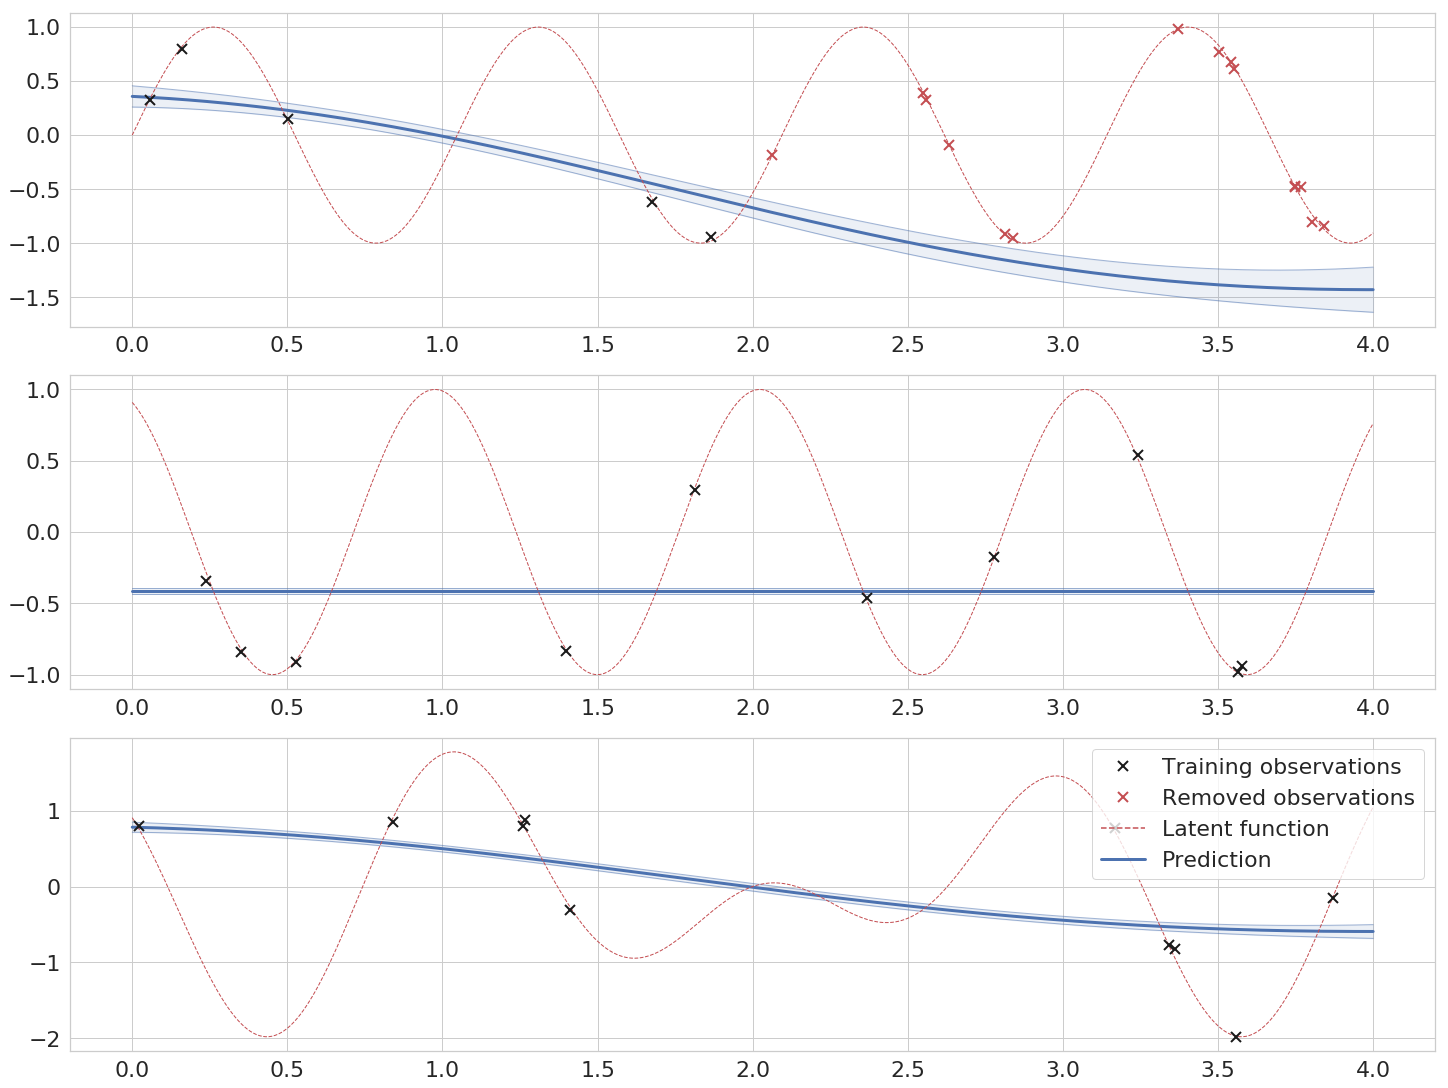

In [32]:
model_cg.set_prediction_range(channel=0, start=0, end=4, step=0.02)
model_cg.set_prediction_range(channel=1, start=0, end=4, step=0.02)
model_cg.set_prediction_range(channel=2, start=0, end=4, step=0.02)
model_cg.predict()

mogptk.plot(model_cg)

## SM-LMC

In [33]:
kernel = mogptk.SM_LMC(data, components=3)
model_smlmc = mogptk.Model(data, kernel)
model_smlmc.optimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8.423167
  Number of iterations: 333
  Number of functions evaluations: 382


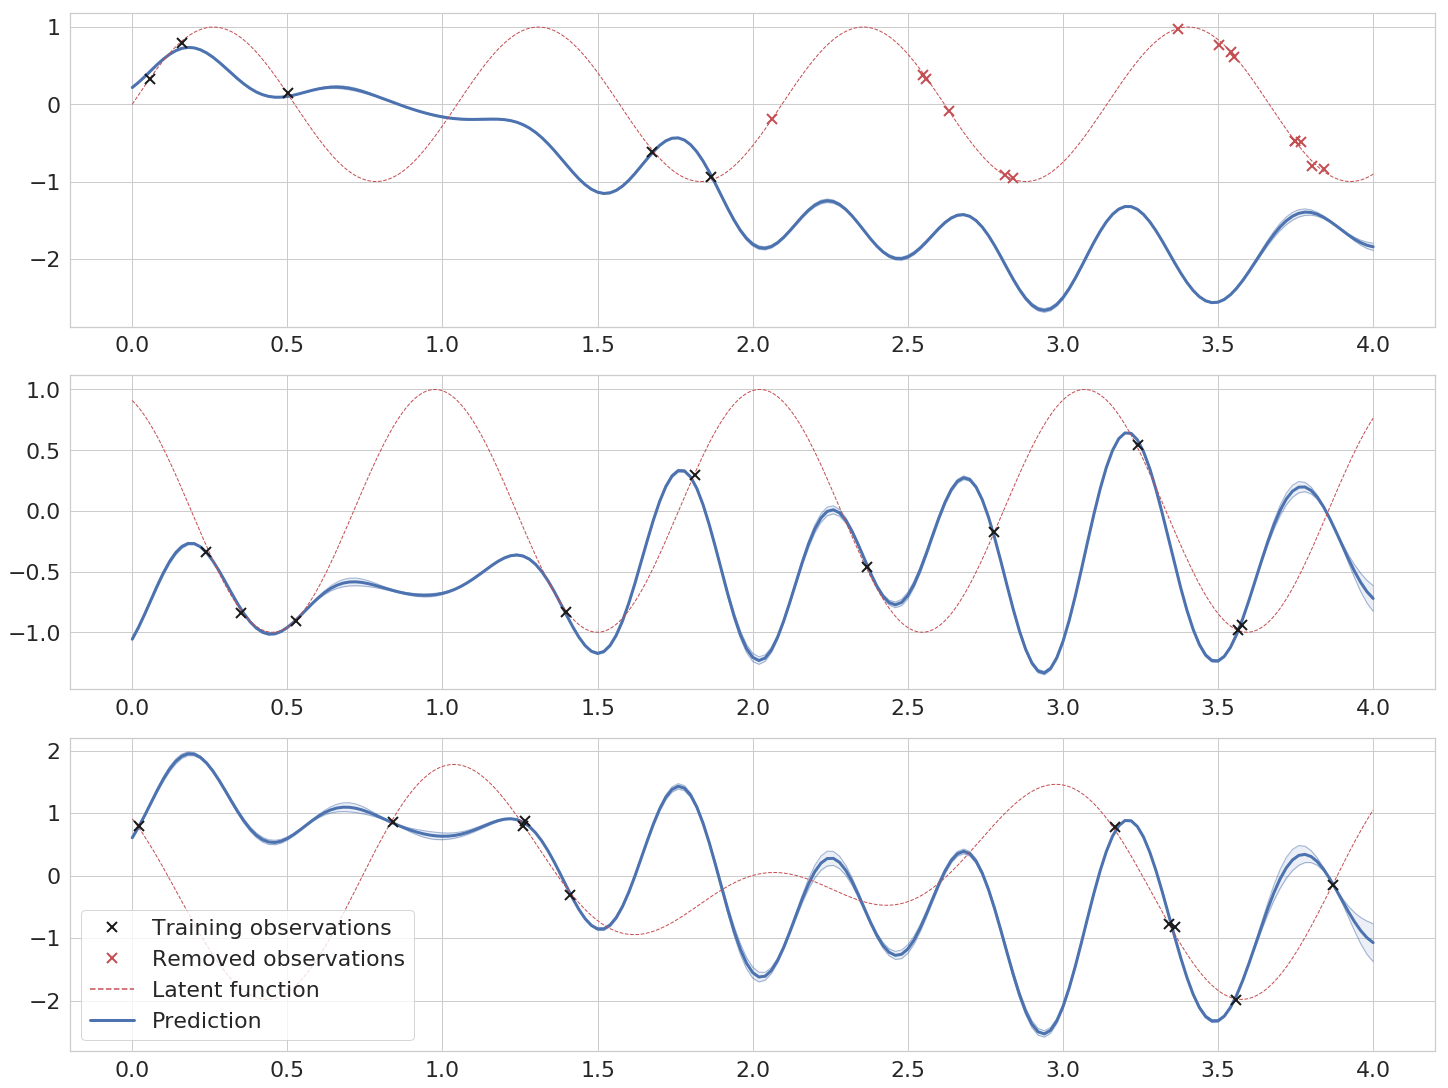

In [34]:
model_smlmc.set_prediction_range(channel=0, start=0, end=4, step=0.02)
model_smlmc.set_prediction_range(channel=1, start=0, end=4, step=0.02)
model_smlmc.set_prediction_range(channel=2, start=0, end=4, step=0.02)
model_smlmc.predict()

mogptk.plot(model_smlmc)

## Error estimation

In [38]:
mogptk.errors(model_mosm, model_csm, model_smlmc, model_cg, print=True)

,MAE,MSE
model,,
MOSM,0.229109,0.092550
CSM,1.316660,2.218845
SM-LMC,1.766250,4.013417
CG,1.154581,1.795751
